**Behavior and Imaging Correlation** 

This notebook provides tools for correlation between the normalized movement of experimental mice and the dF/F calcium two-photon imaging data to investigate possible involvement of recorded neurons in the motor activity from the corresponding video trials.

In [1]:
import os
import json
import scipy
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path
from new_bodypart_calc import adjust_coordinates
from whisker_velocity import velocity

# Input the pathway for the data in question. For CodeOcean, inputs need to be located in the data folder, outputs in scratch.
# If using the code locally, format path as shown below after the hash.

# raw_data_path = Path(f"{os.path.abspath(os.sep)}root") / "capsule" / "data"

raw_data = scipy.io.loadmat('/root/capsule/data/Jan18/bci_session_data/sorted_data/data_behav_BCI29_042222.mat')
trial_csv = '/root/capsule/scratch/DLC_whiskers/trial_00003__2022-04-22_12-09-51/trial_00003__2022-04-22_12-09-51DLC_resnet50_ophys_whiskersJul19shuffle1_100000.csv'
output_path = '/root/capsule/scratch/DLC_whiskers/trial_00003__2022-04-22_12-09-51'
trial_json_path = '/root/capsule/data/single-plane-ophys_608551_2022-04-22_12-39-41/behavior-videos/side/2022-04-22_12-08-56/trial_00003__2022-04-22_12-09-51.json'

The array output from the following cell demonstrates the beginning and end times of trial within a session. For example, trial_00000 was recorded between frames 0 and 248, while trial_00001 was recording between 248 and 729.

In [2]:
# Pull the dF/F values into a variable.
dFF = raw_data['df_closedLoop'] # frames X neurons

# Print out the frame start and end times that correspond to the trials.
trial_start = raw_data['trial_start'].squeeze() # frames
rewards = raw_data['rew'].squeeze()
trial_start_index = np.where(trial_start==1)[0]
trial_start_index

array([    0,   248,   729,   868,  1249,  1453,  1607,  1794,  1950,
        2184,  2879,  3122,  3265,  3585,  3748,  3889,  4154,  4345,
        4519,  4697,  4958,  5226,  5345,  5555,  5705,  5911,  6072,
        6225,  6687,  6804,  7150,  7289,  7712,  7899,  8030,  8386,
        8620,  8854,  8995,  9200,  9369,  9533,  9855, 10080, 10326,
       10533, 10842, 10992, 11221, 11404, 11553, 11756, 11984, 12147,
       12385, 12592, 12785, 13009, 13199, 13445, 13675, 14031, 14265,
       14401, 14517, 14833, 15191, 15642, 15895, 16088, 16289, 16446,
       16611, 16787, 17000, 17204, 17363, 17674, 17877, 18073, 18297,
       18543, 18850, 19084, 19702, 19921, 20074, 20380, 20614, 20886,
       21104, 21367, 21631, 22026, 22230, 22504, 22949, 23175, 23409,
       23546, 24240, 24474, 24628, 24853, 25161, 25413, 25734, 26022,
       26302, 26613, 26901, 27136, 27503, 27843, 28001, 28518, 28987,
       29269, 29417, 29722, 29956, 30293, 30481, 30715, 30971, 31332,
       31489, 31786,

In [3]:
# Two-photon microscope sampling rate.
sampling_rate = 1/raw_data['dt_si'][0][0]
sampling_rate 

19.4141

(-12.450000000000001, 261.45, 0.0, 1.114247311827957)

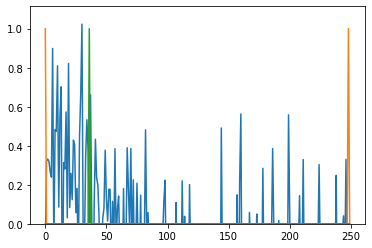

In [4]:
# Graph of dF/F that demonstrates the trials and introduction of rewards.
# Can use indexing to visualize relevant parts of the session.
%matplotlib inline
plt.plot(dFF[:250,1])
plt.plot(trial_start[:250]) 
plt.plot(rewards[:250])
plt.axis(ymin = 0)

In [5]:
# Load behavior information from the trial.
behavior_data = np.load('/root/capsule/data/single-plane-ophys_608551_2022-04-22_12-39-41/behavior/042222-bpod_zaber.npy',
                       allow_pickle = True).tolist()

# Load the name of the specific trials if needed.
face_video_file_names = [y for x,y in zip(behavior_data['scanimage_file_names'],behavior_data['behavior_movie_name_list']) if x != 'no movie for this trial']
face_video_file_names[0][0]

"'/home/labadmin/Data/Behavior_videos/bottom/bci29/2022-04-22_12-09-00/trial_00000__2022-04-22_12-09-00.mp4'"

In [6]:
df = pd.read_csv(trial_csv)

# Extracting the number of frames minus the header.
frames = len(df) - 1

# Opening the JSON file with data for the trial.
with open(trial_json_path) as j:
     trial_frames = json.loads(j.read())

# Calculating the total length of the trial, frame rate of the camera, and number of seconds in between frames.        
trial_length = frames * (trial_frames['frame_times'][2] - trial_frames['frame_times'][1])
frame_rate = frames / trial_length
timing = 1 / frame_rate

In [7]:
# Adjust_coordinates method assumes DLC and LP-generated CSV file format.
# It removes the header and merges two following rows together with an underscore in between.
adjusted_coords_df = adjust_coordinates(trial_csv, output_path)
print(adjusted_coords_df)

1 bodyparts_coords        tongue_tip_x        tongue_tip_y  \
3                0  377.78546142578125   161.1812744140625   
4                1   377.7354736328125   161.1831512451172   
5                2  377.66986083984375   161.1039581298828   
6                3   377.7489318847656  161.28836059570312   
7                4    377.990478515625   161.2630157470703   

1 tongue_tip_likelihood       tongue_mid_x        tongue_mid_y  \
3  0.014401625841856003  369.8410339355469       161.623046875   
4  0.012616433203220367  370.4112548828125  161.77169799804688   
5  0.010352931916713715  358.3264465332031  165.70181274414062   
6  0.014198431745171547  370.2366638183594  162.00975036621094   
7   0.01490817777812481  370.0436706542969  161.71377563476562   

1 tongue_mid_likelihood     whiskert_root_x    whiskert_root_y  \
3  0.014775166288018227  363.39483642578125  87.82731628417969   
4  0.012235159985721111  363.89312744140625    88.013427734375   
5  0.010397054255008698    358.7

{'whiskert_mid1', 'whiskerm_mid2', 'whiskerr_root', 'whiskerr_mid1', 'whiskert_mid2', 'whiskerm_top', 'whiskert_top', 'whiskert_root', 'whiskerm_root', 'whiskerr_top', 'whiskerm_mid1', 'whiskerr_mid2'}
      bodyparts_coords  tongue_tip_x  tongue_tip_y  tongue_tip_likelihood  \
0                    0    377.785461    161.181274               0.014402   
1                    1    377.735474    161.183151               0.012616   
2                    2    377.669861    161.103958               0.010353   
3                    3    377.748932    161.288361               0.014198   
4                    4    377.990479    161.263016               0.014908   
...                ...           ...           ...                    ...   
7699              7699    422.408112    186.342926               0.009151   
7700              7700    422.523682    186.616013               0.005304   
7701              7701    423.259155    187.144699               0.006240   
7702              7702    42

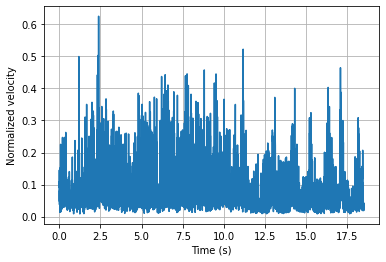

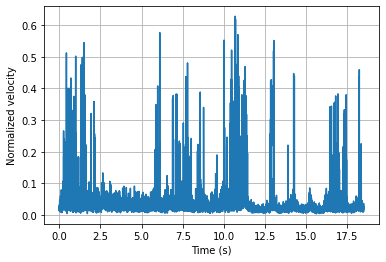

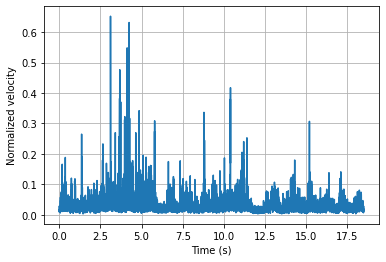

In [8]:
# Calculating velocity for the body parts in question. Go to the "bodypart_calc.py" module to adjust calculation to needed bodyparts.
csv_file = f'/{output_path}/adjusted_coords.csv'
velocity_df = velocity(csv_file, frame_rate, timing)
        
print(velocity_df)

whisker_locs = set([col.split('_')[0] for col in velocity_df.columns[7:79] if '_' in col])
print(whisker_locs)

for whisker_loc in whisker_locs:
    root = f'{whisker_loc}_root_velocity'
    mid1 = f'{whisker_loc}_mid1_velocity'
    mid2 = f'{whisker_loc}_mid2_velocity'
    top = f'{whisker_loc}_top_velocity'

    if root in velocity_df.columns and mid1 in velocity_df.columns and mid2 in velocity_df.columns and top in velocity_df.columns:
        velocity_df[f'{whisker_loc}_velocity'] = (velocity_df[root] + velocity_df[mid1] + velocity_df[mid2] + velocity_df[top]) / 4

velocity_df.to_csv(f'{output_path}/velocity.csv', index = False)

# Change the column names based on the bodypart in question.
for column in velocity_df[['whiskert_velocity', 'whiskerm_velocity', 'whiskerr_velocity']]:
        plt.figure()
        plt.plot(velocity_df['x_rescaled'], velocity_df[column])
        plt.ylabel('Normalized velocity')
        plt.xlabel('Time (s)')
        plt.grid(True)
        plt.show()
        
csv_file = f'{output_path}/velocity.csv'

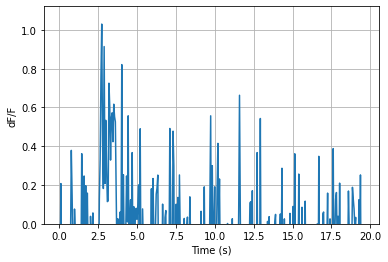

In [9]:
# Creating a calcium imaging dataframe to do further analysis and plot the dF/F/t graph.

dFFt = pd.DataFrame(dFF[868:1249,1])
dFFt.index = dFFt.index / sampling_rate

plt.figure()
plt.plot(dFFt)
plt.xlabel("Time (s)")
plt.ylabel("dF/F")
plt.axis(ymin = 0)
plt.grid(True)
plt.show()

dFFt.to_csv(f'/{output_path}/dFFt_trial.csv')

In [10]:
# Downsampling the velocity dataframe to the same amount of rows as in calcium imaging data.
# Example: there are 21 frames of behavior per 1 frame of calcium imaging for trial_00000.

downsamp_rate = frame_rate / sampling_rate
print(downsamp_rate)

sequence_interval = 1
step_size = np.round(downsamp_rate / sequence_interval).astype("int")

downsamp = pd.read_csv(f'{output_path}/velocity.csv')

downsampled_df = downsamp.iloc[::step_size, :]
downsampled_df.to_csv(f'{output_path}/downsamp.csv')

21.464497087109407


In [11]:
calcium = pd.read_csv(f'/{output_path}/dFFt_trial.csv')
behav = pd.read_csv(f'/{output_path}/downsamp.csv')

# Calculating the correlation coefficient for two paws.
whiskert_cal_beh = calcium.corrwith(behav['whiskert_velocity'], axis=0)
print(f"Correlation coefficient for top whisker is {whiskert_cal_beh['0']}.")
whiskerm_cal_beh = calcium.corrwith(behav['whiskerm_velocity'], axis=0)
print(f"Correlation coefficient for middle whisker is {whiskerm_cal_beh['0']}.")
whiskerr_cal_beh = calcium.corrwith(behav['whiskerr_velocity'], axis=0)
print(f"Correlation coefficient for lower whisker is {whiskerr_cal_beh['0']}.")

Correlation coefficient for top whisker is 0.04011378385945654.
Correlation coefficient for middle whisker is 0.01837099424681545.
Correlation coefficient for lower whisker is 0.10410401094653349.


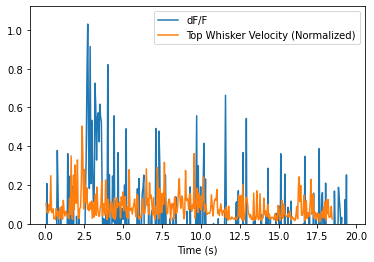

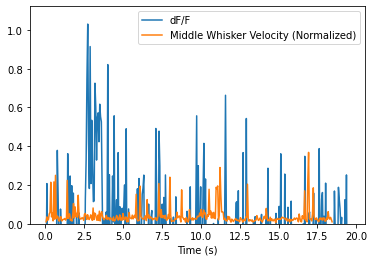

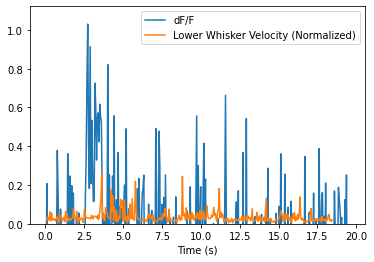

In [12]:
#Creating graphs that demonstrate the concatenation of two normalized graphs.
dFFt['rescaled'] = dFFt.index

ax = dFFt.plot(x='rescaled')
behav.plot(x='x_rescaled', y='whiskert_velocity', ax=ax)
plt.axis(ymin = 0)
plt.legend(('dF/F', 'Top Whisker Velocity (Normalized)'), loc='upper right')
plt.xlabel("Time (s)")
plt.savefig(f'/{output_path}/whiskert.png')

ax = dFFt.plot(x='rescaled')
behav.plot(x='x_rescaled', y='whiskerm_velocity', ax=ax)
plt.legend(('dF/F', 'Middle Whisker Velocity (Normalized)'), loc='upper right')
plt.xlabel("Time (s)")
plt.axis(ymin = 0)
plt.savefig(f'/{output_path}/whiskerm.png')

ax = dFFt.plot(x='rescaled')
behav.plot(x='x_rescaled', y='whiskerr_velocity', ax=ax)
plt.legend(('dF/F', 'Lower Whisker Velocity (Normalized)'), loc='upper right')
plt.xlabel("Time (s)")
plt.axis(ymin = 0)
plt.savefig(f'/{output_path}/whiskerr.png')